# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json
import closs
import ccall

from simplegen import SIMPLESequence
from lastengen import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 7.1) Supervised Euclidean for LASTEN with fixed image
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
store_path = 'experiments/7_1_euclidean'

path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/fix'
path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/train'
path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/test'

#path_fixed = r'D:\Julian\data\SIMPLED\train\0'
#path_train = r'D:\Julian\data\SIMPLED\train'
#path_validation = r'D:\Julian\data\SIMPLED\validation'
#path_test = r'D:\Julian\data\SIMPLED\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=1

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5",
                          period=10)
timelogger = ccall.TimeHistory(store_path)
callbacks = [logger, checker, timelogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')

model.compile(optimizer='adam', loss=eu_loss)

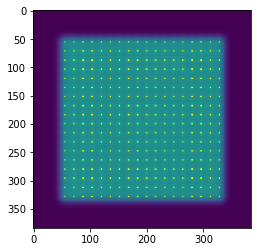

In [8]:
X, y = train_gen[0]

plt.imshow(X[0,:,:,1])

# Training
Run the training.

In [9]:
model.fit(train_gen,
          epochs=2,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Epoch 1/2


/home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


168/168 [==============================] - 53s 315ms/step - loss: 802.2756 - val_loss: 1661.0541
Epoch 2/2
168/168 [==============================] - 53s 318ms/step - loss: 189.7822 - val_loss: 915.5548


# Evaluation
Evaluate the trained network

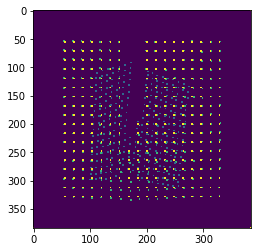

In [14]:
X, y = val_gen[3]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,324):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)